::: {.hidden}
$$
\newcommand{\R}{\mathbb{R}}
\newcommand{\vx}{\mathbf{x}}
\newcommand{\vy}{\mathbf{y}}
\newcommand{\vz}{\mathbf{z}}
\newcommand{\vd}{\mathbf{d}}
\newcommand{\mX}{\mathbf{X}}
\newcommand{\mR}{\mathbf{R}}
\newcommand{\vw}{\mathbf{w}}
\newcommand{\vr}{\mathbf{r}}
\newcommand{\vzero}{\mathbf{0}}
\newcommand{\bracket}[1]{\langle #1 \rangle}
\newcommand{\paren}[1]{\left( #1 \right)}
\newcommand{\one}[1]{\mathbb{1}\left[ #1 \right]}
\newcommand{\cL}{\mathcal{L}}
\newcommand{\cD}{\mathcal{D}}
\newcommand{\cM}{\mathcal{M}}
\newcommand{\mA}{\mathbf{A}}
\newcommand{\vtheta}{\boldsymbol{\theta}}
\newcommand{\norm}[1]{\lVert #1 \rVert}
\newcommand{\abs}[1]{\lvert #1 \rvert}
\newcommand{\prob}[1]{\mathbb{P}\left[#1\right]}
\newcommand{\E}{\mathbb{E}}
\newcommand{\dd}[2]{\frac{\partial #1}{\partial #2}}

\usepackage{amsmath}
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}
$$

:::

Today we are going to study an extremely famous investigation into algorithmic decision-making in the sphere of criminal justice by @angwin2016machine, originally written for ProPublica. This investigation significantly accelerated the pace of research into bias and fairness in machine learning, due in combination to its simple message and publicly-available data.

You've already read about the COMPAS algorithm in [the original article at ProPublica](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing). Our goal today is to reproduce some of the main findings of this article and set the stage for a more systematic treatment of bias and fairness in machine learning. 

*Parts of these lecture notes are inspired by the [original ProPublica analysis](https://github.com/propublica/compas-analysis) and Allen Downey's [expository case study](https://github.com/AllenDowney/RecidivismCaseStudy) on the same data.*

## Data Preparation

Let's first obtain the data. I've hosted a copy on the course website, so we can download it using a URL. 

In [39]:
import pandas as pd
import seaborn as sns
compas_url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/compas-scores-two-years.csv"
compas = pd.read_csv(compas_url)
compas

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,...,2,Low,2014-03-09,2014-03-08,2014-03-09,3,0,754,0,0


For today we are only going to consider a subset of columns. 

In [41]:
cols = ["sex", "race", "decile_score", "two_year_recid"]
compas = compas[cols]
compas

,sex,race,decile_score,two_year_recid
0,Male,Other,1,0
1,Male,African-American,3,1
2,Male,African-American,4,1
3,Male,African-American,8,0
4,Male,Other,1,0
...,...,...,...,...
7209,Male,African-American,7,0
7210,Male,African-American,3,0
7211,Male,Other,1,0
7212,Female,African-American,2,0


We are also only going to consider white (Caucasian) and Black (African-American) defendants: 

In [42]:
# boolean vectors (technically, pd.Series)

is_white = compas["race"] == "Caucasian"
is_black = compas["race"] == "African-American"
compas = compas[is_white | is_black]

compas = compas.copy()

Our data now looks like this: 

In [43]:
compas

,sex,race,decile_score,two_year_recid
1,Male,African-American,3,1
2,Male,African-American,4,1
3,Male,African-American,8,0
6,Male,Caucasian,6,1
8,Female,Caucasian,1,0
...,...,...,...,...
7207,Male,African-American,2,1
7208,Male,African-American,9,0
7209,Male,African-American,7,0
7210,Male,African-American,3,0


## Preliminary Explorations

Let's do some quick exploration of our data. How many defendants are present in this data of each sex? 

In [44]:
compas.groupby("sex").size()

sex
Female    1219
Male      4931
dtype: int64

What about race? 

In [45]:
compas.groupby("race").size()

race
African-American    3696
Caucasian           2454
dtype: int64

The decile score is the algorithm's prediction. Higher decile scores indicate that, according to the COMPAS model, the defendant has higher likelihood to be charged with a crime within the next two years. In the framework we've developed in this class, you can think of the decile score as related to quantities like $\hat{y}_i = \bracket{\vw, \vx_i}$, which is a large number when the algorithm has high confidence in predicting a `1` label. Here, a decile score of `10` indicates high confidence in predicting a `1` (= recidivating) label. 

The easiest way to see how this looks is with a bar chart, which we can make efficiently using the `seaborn` (`sns`) package. 

<AxesSubplot: xlabel='decile_score', ylabel='n'>

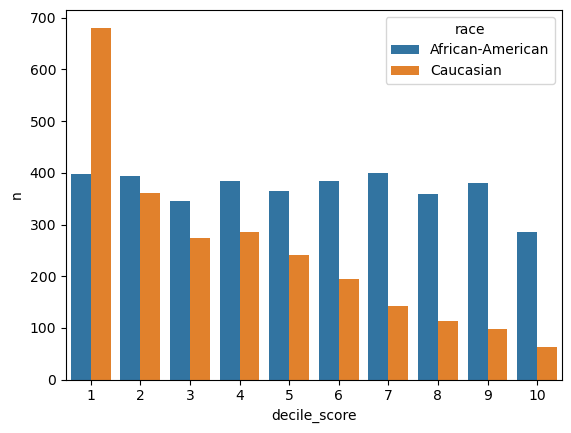

In [49]:
counts = compas.groupby(["race", "decile_score"]).size().reset_index(name = "n")
sns.barplot(data = counts, x = "decile_score", y = "n", hue = "race")

Finally, let's take a look at the recidivism rate in the data: 

In [50]:
compas["two_year_recid"].mean()

0.4661788617886179

So, in this data, approximately 47% of all defendants went on to be charged of another crime within the next two years. We can also compute the recidivism rate by race: 

In [51]:
compas.groupby("race")["two_year_recid"].mean()

race
African-American    0.514340
Caucasian           0.393643
Name: two_year_recid, dtype: float64

## The ProPublica Findings

We're going to treat the COMPAS algorithm as a binary classifier, but you might notice a problem: the algorithm's prediction is the `decile_score` column, which is not actually a `0`-`1` label. Following the analysis of @angwin2016machine, we are going to construct a new binary column in which we say that a defendant is `predicted_high_risk` if their `decile_score` is larger than 4. 

In [54]:
compas["predicted_high_risk"] = 1*(compas["decile_score"] > 4)

Now we have a binary prediction, and we can compute things like confusion matrices: 

In [59]:
from sklearn.metrics import confusion_matrix
confusion_matrix(compas["two_year_recid"], compas["predicted_high_risk"], normalize = "true")

array([[0.64849223, 0.35150777],
       [0.34635507, 0.65364493]])

In [58]:
(compas["two_year_recid"] == compas["predicted_high_risk"]).mean()

0.6508943089430894

We can normalize this confusion matrix to get things like the false positive and false negative rates: 

We see that the algorithm (predicting recidivism if `decile_score` is 5 or above) is right about 65% of the time. A bit more specifically, both the true positive (TP) and true negative (TN) rates are approximately 65%. Both the false positive (FP) and false negative (FN) rates are approximately 35%. 

We can also check the overall accuracy:

The accuracy is relatively consistent even when we break things down by race: 

However, and this was the main finding of the ProPublica study, the FPR and FNR are very different when we break down the data by race. Here's the confusion matrix for Black defendants: 

In [60]:
confusion_matrix(compas["two_year_recid"][is_black], 
                 compas["predicted_high_risk"][is_black], 
                 normalize = "true")

array([[0.55153203, 0.44846797],
       [0.27985271, 0.72014729]])

And here it is for white defendants: 

In [61]:
confusion_matrix(compas["two_year_recid"][is_white], 
                 compas["predicted_high_risk"][is_white], 
                 normalize = "true")

array([[0.76545699, 0.23454301],
       [0.47722567, 0.52277433]])

The ProPublica study focused on the false positive rate (FPR), which is in the top right corner of the confusion matrices. The FPR of 44% for Black defendants means that, out of every 100 Black defendants who *in fact will not commit another crime*, the algorithm nevertheless predicts that 44 of them will. In contrast, the FPR of 23% for white defendants indicates that only 23 out of 100 non-recidivating white defendants would be predicted to recidivate. 

There are a few ways in which we can think of this result as reflecting bias: 

- The algorithm has learned an implicit pattern wherein Black defendants are intrinsically more "criminal" than white defendants, even among people who factually never committed another crime. This is a bias in the patterns that the algorithm has learned in order to formulate its predictions. This is related to ***representational bias***, which we'll discuss more later in the semester. 
- Regardless of how the algorithm forms its predictions, the *impact* of the algorithm being used in the penal system is that more Black defendants will be classified as high-risk, resulting in more denials of parole, bail, early release, or other forms of freedom from the penal system. So, the algorithm has disparate *impact* on people. We might claim this as a form of ***allocative bias***: bias in how resources or opportunities (in this case, freedom) are allocated between groups. 

[Sometimes predictive equality is also defined to require that the false negative rates (FNRs) be equal across the two groups as well.]{.aside}

In the language of @corbett2017algorithmic, an algorithm that has equal FPRs across two groups satisfies ***predictive equality*** with respect to those two groups. So, the COMPAS algorithm fails to possess predictive equality. The idea of *error rate balance* in @chouldechova2017fair and *balance for the positive/negative class* in @kleinberg2016inherent are similar to predictive equality. 

In summary, the ProPublica argument was: 

> Since the FPR differs across racial groups in ways that reinforce the oppression of Black people, the COMPAS algorithm possesses racial bias. 


## Calibration

Is that the end of the story? Emphatically not! @angwin2016machine kicked off a vigorous discussion about what it means for an algorithm to fair and how to measure deviations from bias. For example, @corbett2017algorithmic consider a different idea of fairness. While predictive equality requires that the FPRs for white and Black defendants be equal, *calibration* expresses a different intuition: 

> A white defendant and a Black defendant who each receive the same score should both have the same risk of recidivating. 

[Compare: an "A" in CS 201 means the same thing for your future success in CS, no matter your gender.]{.aside}
Another way to say this is that a score of 7 means the same thing, no matter the race of the defendant. 

We can compute the recidivism rates for each race at each decile score using some Pandas `.groupby` magic: 

In [62]:
compas.groupby(["race", "predicted_high_risk"])["two_year_recid"].mean()

race              predicted_high_risk
African-American  0                      0.349540
                  1                      0.629715
Caucasian         0                      0.288125
                  1                      0.591335
Name: two_year_recid, dtype: float64

The actual recidivism rate at each risk score is roughly the same between Black and white defendants, especially for decile scores past 5 or so. 

## Calibration for Binary Classifiers

So far in this course, we have primarily studied binary classifiers that produce a single 0-1 predicted label, rather than a score like a decile. For these classifiers, calibration means that *the fraction of predicted recidivists who actually recidivated is the same across groups*. If we follow the @angwin2016machine approach and say that the algorithm predicts someone as high risk if their decile score is 4 or above, we would obtain the following results: 

There are arguments to be had here, but from the perspective of calibration at the decile score threshold of 4, the algorithm might appear to be biased in the other direction: of those who were predicted high risk, slightly more Black than white defendants were arrested within the next two years. In most of the published literature, scholars have considered that the two rates are sufficiently close that we should instead simply say that COMPAS appears to be reasonably well calibrated. 

## Overcoming Bias?

Ok, so COMPAS is reasonably *calibrated*, but does not satisfy *predictive equality*. Couldn't we just find a way to fix it so that it could be both calibrated and predictively equitable? A little fine-tuning here and there maybe? Sadly, no: this is not just difficult, but actually mathematically impossible, as shown by  @chouldechova2017fair.  

@kleinberg2016inherent give some other definitions of fairness in algorithmic decision-making, again concluding that several concepts of fairness mathematically exclude other ones. 
